Example file which shows some simple curve fitting using DARTSRegressor and some other estimators.

In [4]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from aer.skl.darts import DARTSRegressor, ValueType

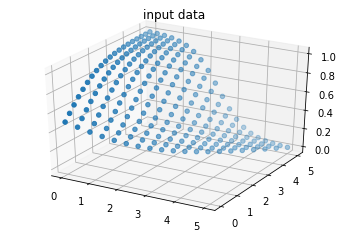

In [5]:
# %% Define some helper functions


def show_results_complete(
    data_: pd.DataFrame,
    estimator=None,
    show_results=True,
    projection="2d",
    label=None,
):
    """
    Function to plot input data (x_, y_) and the predictions of an estimator for the same x_.
    """
    if projection == "2d":
        plt.figure()
        data_.plot.scatter(
            "S1", "S2", c="difference_detected", cmap="viridis", zorder=10
        )
    elif projection == "3d":
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.scatter(data_["S1"], data["S2"], data["difference_detected"])

        if estimator is not None:
            xs, ys = np.mgrid[0:5:0.2, 0:5:0.2]  # type: ignore

            zs = estimator.predict(np.column_stack((xs.ravel(), ys.ravel())))

            ax.plot_surface(xs, ys, zs.reshape(xs.shape), alpha=0.5)

    if label is not None:
        plt.title(label)

    if show_results:
        plt.show()

    return


# %% Load the data
datafile_path = "./weber_data.csv"
data = pd.read_csv(datafile_path)
show_results = partial(show_results_complete, data_=data, projection="3d")
show_results(label="input data")

X = data[["S1", "S2"]]
y = data["difference_detected"]

/Users/jholla10/Library/Caches/pypoetry/virtualenvs/aer-2PgcgopX-py3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


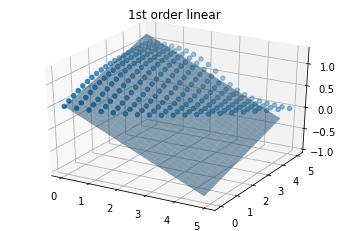

In [6]:
# %% Fit first using a super-simple linear regression

first_order_linear_estimator = LinearRegression()
first_order_linear_estimator.fit(X, y)

show_results(estimator=first_order_linear_estimator, label="1st order linear")

/Users/jholla10/Library/Caches/pypoetry/virtualenvs/aer-2PgcgopX-py3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


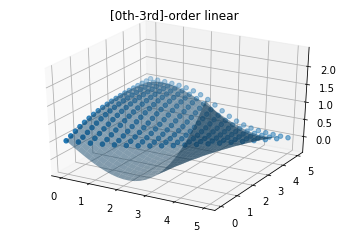

In [7]:
# %% Fit using a 0-3 order polynomial, getting the best fit for the data.
polynomial_estimator = GridSearchCV(
    make_pipeline(PolynomialFeatures(), LinearRegression(fit_intercept=False)),
    param_grid=dict(polynomialfeatures__degree=range(4)),
)
polynomial_estimator.fit(X, y)

show_results(estimator=polynomial_estimator, label="[0th-3rd]-order linear")

  0%|          | 0/30 [00:00<?, ?it/s]

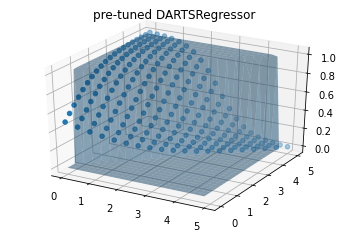

Edge (0): -3.8209 * x
Edge (1): 4.1676 * x + -1.8289
Edge (2): -3.8209 * x
Edge (3): 4.1676 * x + -1.8289
Edge (4): 4.1676 * x + -1.8289
Classifier from Edge 0: x.*(3.0628) .+(-0.4261)
Classifier from Edge 1: x.*(2.3446)


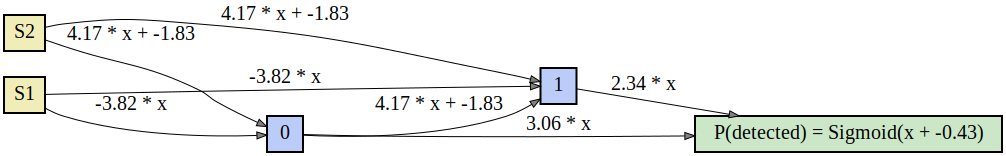

In [8]:
darts_estimator_tuned = DARTSRegressor(
    batch_size=64,
    arch_updates_per_epoch=1,
    param_updates_per_epoch=500,
    max_epochs=30,
    output_type=ValueType.PROBABILITY,
    num_graph_nodes=2,
)

darts_estimator_tuned.fit(X, y)

show_results(estimator=darts_estimator_tuned, label="pre-tuned DARTSRegressor")
darts_estimator_tuned.visualize_model()

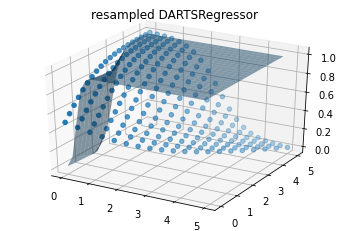

Edge (0): 
Edge (1): 4.0708 * x + -1.7804
Edge (2): 4.0708 * x + -1.7804
Edge (3): -3.7213 * x
Edge (4): ReLU(-0.4935 * x + 1.7936)
Classifier from Edge 0: x.*(2.9914) .+(-0.4147)
Classifier from Edge 1: x.*(2.2913)


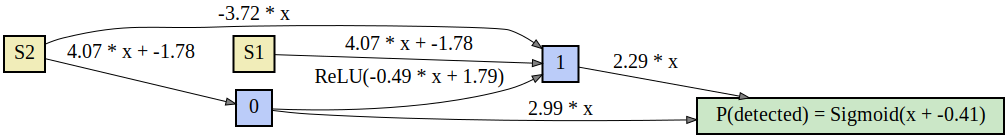

In [9]:
darts_estimator_tuned.resample_model(sampling_strategy="sample")
show_results(estimator=darts_estimator_tuned, label="resampled DARTSRegressor")
darts_estimator_tuned.visualize_model()
